## generate previous frames with pCO2 and fit it against ConvLSTM for multiple members

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os

sys.path.insert(0, '../../src')
from sklearn.metrics import mean_squared_error
from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2024-07-16 21:10:44.734653: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2024-07-16 21:10:44.734674: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.14.1


In [3]:
dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)

def custom_rmse2(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    + difference between sss
    """
    idx  = tf.not_equal(y_true, 0.0)
    idx2  = tf.equal(y_true, 0.0)
    
    y_pred1 = tf.boolean_mask(y_pred,idx)
    y_true1 = tf.boolean_mask(y_true,idx)
    y_true1 = tf.cast(y_true1, y_pred.dtype)
    
    rmse1 = K.sqrt(K.mean(tf.math.squared_difference(y_pred1, y_true1),axis= -1))
    
    #y_pred2 = tf.boolean_mask(y_pred,idx2)
    #loss2 = 10*(K.var(y_true1)/K.var(y_pred2))
    #loss2 = tf.cast(loss2, y_pred.dtype)
    
    return rmse1

In [4]:
mpi_data_path = "../../data/mpi_001"


def read_xarray_mpi(dir_name="",num="006"):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature mpi
    '''
    date="198201-201701"
  
    file_type ="MPI"
        
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}{num}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}{num}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}{num}_1x1_{date}.nc')

    return chl,mld,sss,sst,xco2,pco2


chl,mld,sss,sst,xco2,pco2 = read_xarray_mpi(mpi_data_path)

# def pco2_socat_preprocess(arr):
#     tmp_arr=arr[arr!=0.0]
#     coord = ((arr==0))
#     min_pixel, max_pixel = np.nanmin(tmp_arr), np.nanmax(tmp_arr)
    
#     output = (arr-min_pixel)*(255)/(max_pixel-min_pixel)
#     output[coord]=0
#     return output, min_pixel, max_pixel

# def inverse_pco2_socat(arr,min_pixel,max_pixel=1000):
#     y_pred = arr*(max_pixel-min_pixel)/255+min_pixel
#     return y_pred

def pco2_socat_preprocess(arr):
    nans=np.isnan(arr)
    min_val=arr[~nans].min()
    arr[nans]=min_val
    return arr

/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


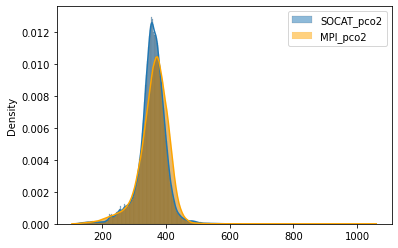

In [7]:
# Data distribution
import seaborn as sns

# SOCAT
_,_,_,_,_,_,_,_,socat = read_xarray("../../data/member_001",num ="001")
socat = np.nan_to_num(socat.pCO2_socat.data, 0.)
sns.histplot(socat[socat != socat.min()],stat='density',label='SOCAT_pco2',kde=True)

# GOBM
gobm = pco2.pCO2.data
sns.histplot(gobm[gobm != gobm.min()], stat='density',label='MPI_pco2',kde=True,color='orange')

plt.legend()
plt.show()

## transfer learning on MPI


In [15]:
chl_images = preprocess_image_reduced(chl.Chl.data)
sss_images = preprocess_image_reduced(sss.SSS.data)
sst_images = preprocess_image_reduced(sst.SST.data)
mld_images = preprocess_image_reduced(mld.MLD.data)
xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
pco2_socat_images= pco2_socat_preprocess(pco2.pCO2_socat.data)

dist_map = preprocess_image_reduced(dist_map)

X_tf = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
y_tf = pco2_socat_images
X_tf = X_tf.reshape((421,180,360,5),order='F')
frame = 1
X_index=np.lib.stride_tricks.sliding_window_view(range(421),frame)
X2_tf = X_tf[X_index][:-1]
y2_tf=pco2_socat_images[X_index][1:]
X_tf,y_tf=X_tf[:421-frame],y_tf[:421-frame]


In [16]:
X_tf.shape, y_tf.shape, X2_tf.shape, y2_tf.shape

((420, 180, 360, 5),
 (420, 180, 360),
 (420, 1, 180, 360, 5),
 (420, 1, 180, 360))

In [17]:
np.min(pco2_socat_images), np.max(pco2_socat_images), np.std(pco2_socat_images)

(0.0, 710.2517700195312, 34.770610971137785)

In [18]:
tf.keras.backend.clear_session()

# transfer learning
model_path="../../models/pretrain_final.h5"
model = tf.keras.models.load_model(model_path, custom_objects={'custom_rmse':custom_rmse})


ls=[12,13,14,15,16,17,18,19,24,25,26,27,28,29,30]

ind=0

for layer in model.layers:
    if ind not in ls:
        layer.trainable = False
    else:
        layer.trainable = True
        print(str(ind),":",layer)
    ind+=1

model.summary()

12 : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1554ab6c1b50>
13 : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1554ab6c1b80>
14 : <tensorflow.python.keras.layers.core.Dropout object at 0x1554ab6c20a0>
15 : <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x1554ab6c2730>
16 : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1554ab6c2a90>
17 : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1554ab6c2ac0>
18 : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1554ab6c02e0>
19 : <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1554ab6c0b50>
24 : <tensorflow.python.keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x15549dcd3d00>
25 : <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x15549dcd8910>
26 : <tensorflow.python.keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x15549dcd8b20>
27 : <tensorflow.python.keras.lay

In [19]:
ref_image,ref_frames = model.predict([X_tf,X2_tf],verbose=1)

14/14 [==============================] - 60s 4s/step


In [21]:
chl,mld,sss,sst,xco2,pco2 = read_xarray_mpi(mpi_data_path)

full_truth, full_socat_truth = np.nan_to_num(pco2.pCO2.data[:420]), np.nan_to_num(pco2.pCO2_socat.data[:420])
coord = (full_truth==0.0)
coord_socat = (full_socat_truth==0.0)
ref_socat_image = ref_image.copy()
ref_image[coord] = 0
ref_socat_image[coord_socat] = 0

# Extrapolation/interpolation pretraining results (unet)
print(np.sqrt(mean_squared_error(ref_image.flatten(), full_truth.flatten())))
print(np.sqrt(mean_squared_error(ref_socat_image.flatten(), full_socat_truth.flatten())))

tmp, tmp_socat = np.nan_to_num(pco2.pCO2.data[X_index][1:]), np.nan_to_num(pco2.pCO2_socat.data[X_index][1:])
y_true_full, y_true_socat_full = np.expand_dims(tmp,axis=4), np.expand_dims(tmp_socat,axis=4)

coord2 = (y_true_full==0.0)
coord2_socat = (y_true_socat_full==0.0)
ref_socat_frames = ref_frames.copy()
ref_frames[coord2] = 0
ref_socat_frames[coord2_socat] = 0

# Extrapolation/interpolation pretraining results (convlstm)
print(np.sqrt(mean_squared_error(ref_frames.flatten(), y_true_full.flatten())))
print(np.sqrt(mean_squared_error(ref_socat_frames.flatten(), y_true_socat_full.flatten())))

216.41425
26.1717421111927
206.34653
24.957187307066352


In [23]:
model_path="../../models/transfer_CONVLSTM_mpi2.h5"

In [24]:
# Training...

# from tensorflow.keras import backend as K

# myLearnRate=0.002

# model.compile(
#     loss=[custom_rmse,custom_rmse], optimizer=keras.optimizers.Adam(learning_rate=myLearnRate),
# )

# early_stopings = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='min')
# checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='loss', save_best_only=True, mode='min', verbose=0)
# callbacks=[early_stopings,checkpoint]

# history = model.fit([X_tf,X2_tf],[y_tf,y2_tf], epochs=30, 
#                          workers=-1,batch_size=16,
#                          callbacks=callbacks)

In [25]:
cnn_model = tf.keras.models.load_model(model_path, custom_objects={'custom_rmse':custom_rmse})
predicted_image,predicted_frames = cnn_model.predict([X_tf,X2_tf],verbose=1)

14/14 [==============================] - 60s 4s/step


In [26]:
chl,mld,sss,sst,xco2,pco2 = read_xarray_mpi(mpi_data_path)

full_truth, full_socat_truth = np.nan_to_num(pco2.pCO2.data[:420]), np.nan_to_num(pco2.pCO2_socat.data[:420])
coord = (full_truth==0.0)
coord_socat = (full_socat_truth==0.0)
predicted_socat_image = predicted_image.copy()
predicted_image[coord] = 0
predicted_socat_image[coord_socat] = 0

# Extrapolation/interpolation pretraining results (unet)
print(np.sqrt(mean_squared_error(predicted_image.flatten(), y_true_full.flatten())))
print(np.sqrt(mean_squared_error(predicted_socat_image.flatten(), y_true_socat_full.flatten())))

tmp, tmp_socat = np.nan_to_num(pco2.pCO2.data[X_index][1:]), np.nan_to_num(pco2.pCO2_socat.data[X_index][1:])
y_true_full, y_true_socat_full = np.expand_dims(tmp,axis=4), np.expand_dims(tmp_socat,axis=4)

coord2 = (y_true_full==0.0)
coord2_socat = (y_true_socat_full==0.0)
predicted_socat_frames = predicted_frames.copy()
predicted_frames[coord2] = 0
predicted_socat_frames[coord2_socat] = 0

# Extrapolation/interpolation transfer results 
print(np.sqrt(mean_squared_error(predicted_frames.flatten(), y_true_full.flatten())))
print(np.sqrt(mean_squared_error(predicted_socat_frames.flatten(), y_true_socat_full.flatten())))

41.079468
43.003563391316256
30.238848
2.0493168606904595


### Graph

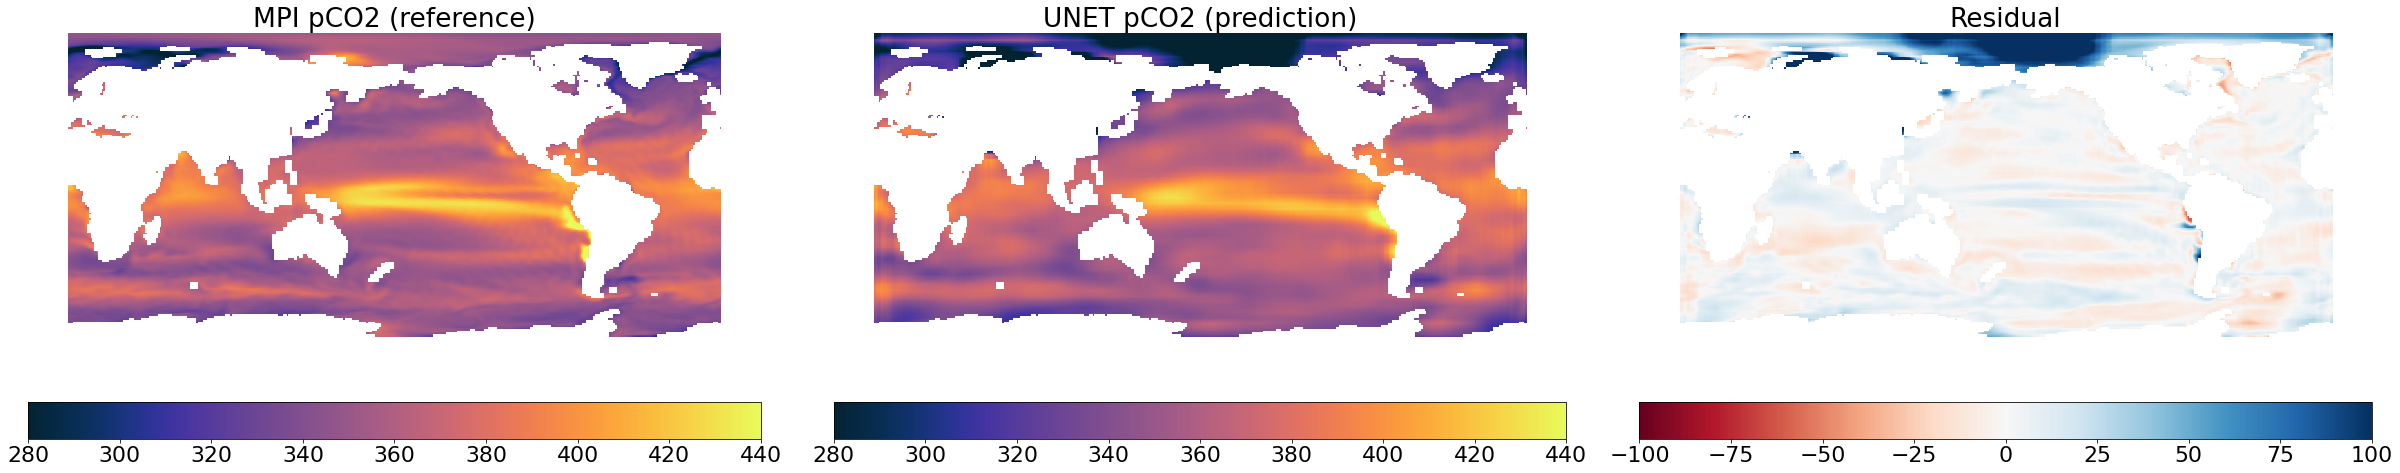

In [16]:
# CNN average Image
full_truth[coord] = np.nan
predicted_image[coord] = np.nan

res_unet = full_truth - predicted_image

avg_y_true = np.mean(full_truth,axis=0)
avg_y_pred = np.mean(predicted_image,axis=0)
avg_res = np.mean(res_unet,axis=0)

import cmocean as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure, axis = plt.subplots(1, 3,figsize=(42, 8))

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

im0 = axis[0].imshow(np.flipud(avg_y_true[-168:]),cmap = cm.cm.thermal,norm=norm)
cbar0 = figure.colorbar(im0, ax=axis[0], orientation='horizontal')
axis[0].set_title("MPI pCO2 (reference)")
axis[0].axis('off')

# divider = make_axes_locatable(axis[0])
# cax = divider.append_axes('right', size='2%', pad=0.15)
# cbar=figure.colorbar(im0, cax=cax, orientation='vertical')
# cbar.ax.get_yaxis().labelpad = 20
# cbar.ax.set_ylabel('pCO2', rotation=270)
# cbar.set_ticklabels(np.arange(280,440,20))


im1 =axis[1].imshow(np.flipud(avg_y_pred[-168:]),cmap = cm.cm.thermal,norm=norm)
cbar1 = figure.colorbar(im1, ax=axis[1], orientation='horizontal')
axis[1].set_title("UNET pCO2 (prediction)")
axis[1].axis('off')

# divider = make_axes_locatable(axis[1])
# cax = divider.append_axes('right', size='2%', pad=0.15)
# cbar2=figure.colorbar(im1, cax=cax, orientation='vertical')
# cbar2.ax.get_yaxis().labelpad = 20
# cbar2.ax.set_ylabel('pred', rotation=270)
# cbar2.set_ticklabels(np.arange(280,440,20))


im2=axis[2].imshow(np.flipud(avg_res[-168:]),cmap = "RdBu",norm=norm2)
cbar2 = figure.colorbar(im2, ax=axis[2], orientation='horizontal')
axis[2].set_title("Residual")
axis[2].axis('off')

# divider = make_axes_locatable(axis[2])
# cax = divider.append_axes('right', size='2%', pad=0.15)
# cbar3=figure.colorbar(im2, cax=cax, orientation='vertical')
# cbar3.ax.get_yaxis().labelpad = 20
# cbar3.ax.set_ylabel('residual', rotation=270)
# cbar3.set_ticklabels(np.arange(-100,100,25))

plt.subplots_adjust(wspace=0.1)
# figure.suptitle("Average canESM Transfer Learning pCO2 | Prediction | Residual - over 1987/02-2017/01")
plt.savefig("../../assets/figure6.0_unet_mpi2.jpg", dpi=200)

### ConvLSTM

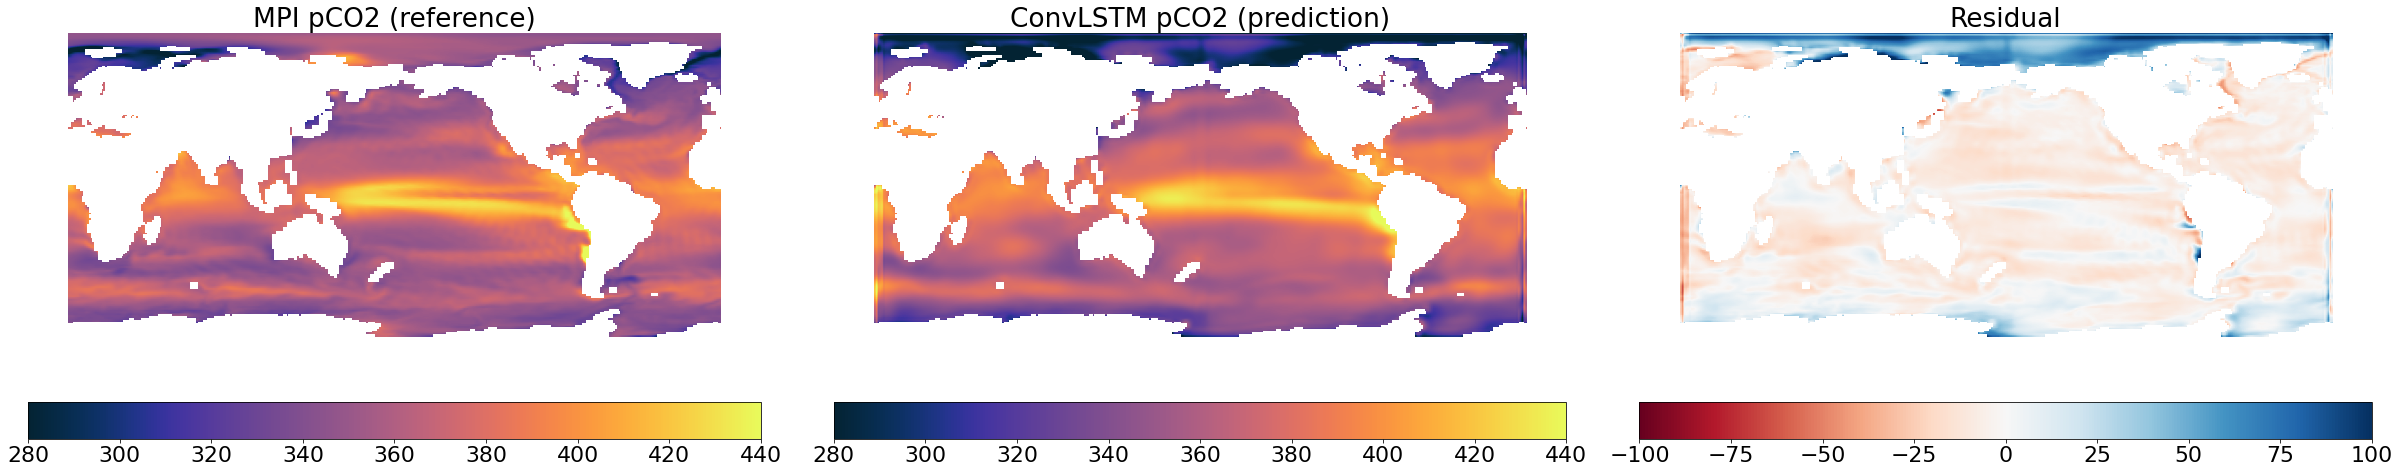

In [18]:
# ConvLSTM average Image
import cmocean as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
predicted_frames[coord2] = np.nan
y_true_full[coord2] = np.nan
avg_y_pred = np.mean(predicted_frames[:],axis=0)
avg_y_true = np.mean(y_true_full[:],axis=0)

res = y_true_full[:]-predicted_frames[:]
avg_res = np.mean(res,axis=0)
figure, axis = plt.subplots(1, 3,figsize=(42, 8))

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

im0 = axis[0].imshow(np.flipud(avg_y_true[0,-168:]),cmap = cm.cm.thermal,norm=norm)
cbar0 = figure.colorbar(im0, ax=axis[0], orientation='horizontal')
axis[0].set_title("MPI pCO2 (reference)")
axis[0].axis('off')

# divider = make_axes_locatable(axis[0])
# cax = divider.append_axes('right', size='5%', pad=0.3)
# cbar=figure.colorbar(im0, cax=cax, orientation='vertical')
# cbar.ax.get_yaxis().labelpad = 20
# cbar.ax.set_ylabel('pCO2', rotation=270)
# cbar.set_ticklabels(np.arange(280,440,20))

im1 =axis[1].imshow(np.flipud(avg_y_pred[0,-168:]),cmap = cm.cm.thermal,norm=norm)
cbar1 = figure.colorbar(im1, ax=axis[1], orientation='horizontal')
axis[1].set_title("ConvLSTM pCO2 (prediction)")
axis[1].axis('off')

# divider = make_axes_locatable(axis[1])
# cax = divider.append_axes('right', size='5%', pad=0.3)
# cbar2=figure.colorbar(im1, cax=cax, orientation='vertical')
# cbar2.ax.get_yaxis().labelpad = 20
# cbar2.ax.set_ylabel('pred', rotation=270)
# cbar2.set_ticklabels(np.arange(280,440,20))

im2=axis[2].imshow(np.flipud(avg_res[0,-168:]),cmap = "RdBu",norm=norm2)
cbar2 = figure.colorbar(im2, ax=axis[2], orientation='horizontal')
axis[2].set_title("Residual")
axis[2].axis('off')

# divider = make_axes_locatable(axis[2])
# cax = divider.append_axes('right', size='5%', pad=0.3)
# cbar3=figure.colorbar(im2, cax=cax, orientation='vertical')
# cbar3.ax.get_yaxis().labelpad = 20
# cbar3.ax.set_ylabel('residual', rotation=270)
# cbar3.set_ticklabels(np.arange(-100,100,20))

plt.subplots_adjust(wspace=0.1)
# figure.suptitle("Average CONVLSTM MPI Transfer Learning pCO2 | Prediction | Residual - over 1987/02-2017/01")
plt.savefig("../../assets/figure6.0_convlstm_MPI.jpg", dpi=200)

(420, 1, 180, 360, 1)
(420, 1)


/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


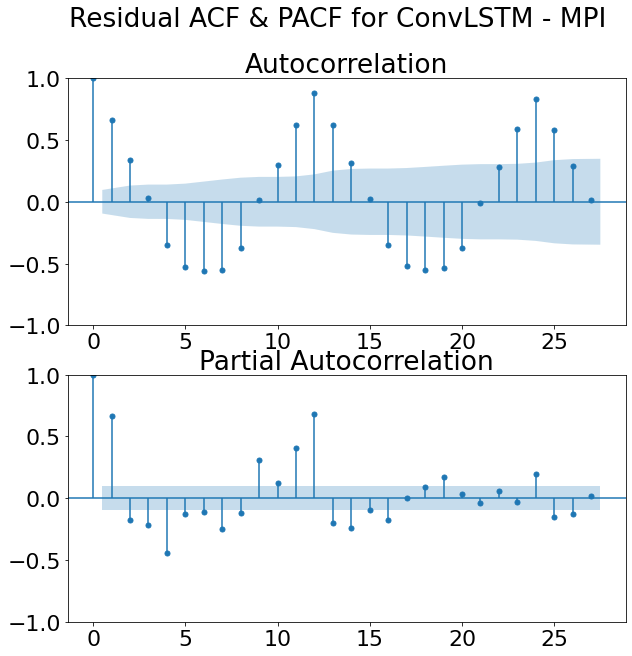

In [14]:
y_true_full[coord2]=np.nan
predicted_frames[coord2]=np.nan

res = y_true_full[:]-predicted_frames[:]

print(res.shape)

avg_time_res_convlstm=np.nanmean(res, axis=(1,2,3))
print(avg_time_res_convlstm.shape)

fig = pyplot.figure(figsize = (10,10))
pyplot.subplot(211)
plot_acf(avg_time_res_convlstm, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(avg_time_res_convlstm, ax=pyplot.gca())

fig.suptitle("Residual ACF & PACF for ConvLSTM - MPI")
plt.savefig("../../assets/figure7_convLSTM_mpi_acf.jpg")
pyplot.show()

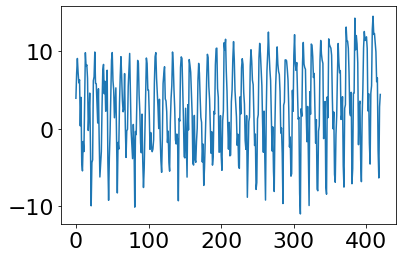

In [44]:
plt.plot(avg_time_res_convlstm)